In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [1]:
words = open('french-first-names.txt', 'r').read().splitlines()


In [3]:
words.pop(0)

'01_prenom'

In [4]:
words[:10]


['aaliyah',
 'aapeli',
 'aapo',
 'aaren',
 'aarne',
 'aarón',
 'aaron',
 'aatami',
 'aatto',
 'aatu']

In [6]:
len(words)

11627

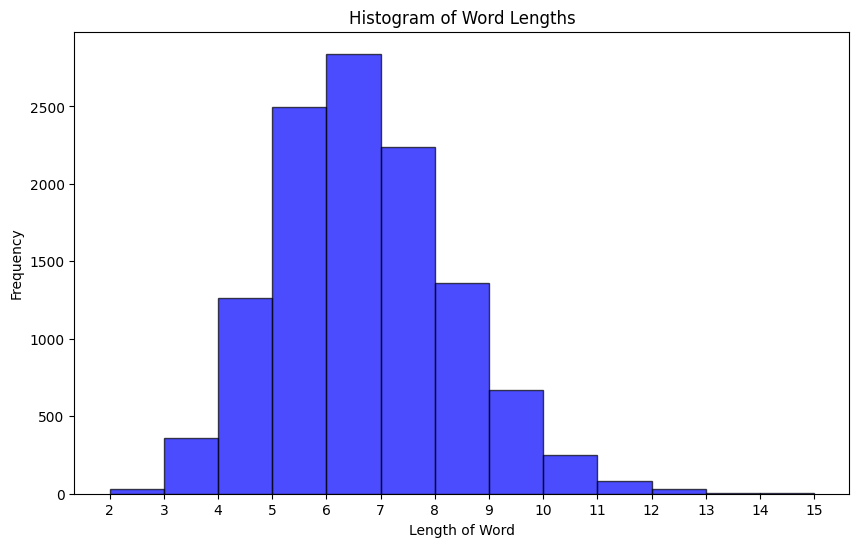

In [11]:
lengths = [len(w) for w in words]

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=range(min(lengths), max(lengths) + 1, 1), alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of Word Lengths')
plt.xlabel('Length of Word')
plt.ylabel('Frequency')
plt.xticks(range(min(lengths), max(lengths) + 1, 1))
plt.show()

In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: "'", 3: '-', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z', 30: 'à', 31: 'á', 32: 'ã', 33: 'ä', 34: 'å', 35: 'æ', 36: 'ç', 37: 'è', 38: 'é', 39: 'ê', 40: 'ë', 41: 'ì', 42: 'í', 43: 'ï', 44: 'ð', 45: 'ñ', 46: 'ò', 47: 'ó', 48: 'ô', 49: 'õ', 50: 'ö', 51: 'ø', 52: 'ù', 53: 'ú', 54: 'ü', 55: 'þ', 0: '.'}


In [8]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [9]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([83799, 3]), torch.int64, torch.Size([83799]), torch.int64)

In [12]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([67073, 3]) torch.Size([67073])
torch.Size([8307, 3]) torch.Size([8307])
torch.Size([8419, 3]) torch.Size([8419])


In [14]:
C = torch.randn((57, 2))


In [15]:
emb = C[X]
emb.shape

torch.Size([83799, 3, 2])

In [16]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [30]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape


torch.Size([83799, 6])

In [32]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([83799, 6])

In [17]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[-0.8138, -0.9916,  0.9964,  ..., -0.5335, -0.8879, -0.9992],
        [ 0.9955,  0.8768,  0.7253,  ...,  0.8727, -0.9996, -1.0000],
        [ 1.0000,  1.0000,  0.0240,  ...,  0.9789, -1.0000, -0.9999],
        ...,
        [ 0.9948, -0.9973,  0.7959,  ..., -0.9995, -0.7368, -0.9941],
        [ 0.1229,  0.2991, -0.7720,  ...,  0.6202, -0.9957, -0.9558],
        [ 0.9573,  0.9873,  0.9997,  ...,  0.8774, -0.9959, -0.9996]])

In [18]:
h.shape

torch.Size([83799, 100])

In [19]:
W2 = torch.randn((100, 57))
b2 = torch.randn(57)

In [20]:
logits = h @ W2 + b2


In [21]:
logits.shape

torch.Size([83799, 57])

In [22]:
counts = logits.exp()


In [23]:
prob = counts / counts.sum(1, keepdims=True)


In [24]:
prob.shape

torch.Size([83799, 57])

In [27]:
loss = -prob[torch.arange(83799), Y].log().mean()
loss

tensor(16.9203)

# ------------ now made respectable  ---------------


In [33]:
Xtr.shape, Ytr.shape # dataset


(torch.Size([67073, 3]), torch.Size([67073]))

In [34]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((57, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 57), generator=g)
b2 = torch.randn(57, generator=g)
parameters = [C, W1, b1, W2, b2]

In [35]:
sum(p.nelement() for p in parameters) # number of parameters in total


18227

In [36]:
for p in parameters:
  p.requires_grad = True

In [37]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [38]:
lri = []
lossi = []
stepi = []

In [39]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (57,))

  # forward pass
  emb = C[Xtr[ix]] # (83799, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (83799, 200)
  logits = h @ W2 + b2 # (83799, 57)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

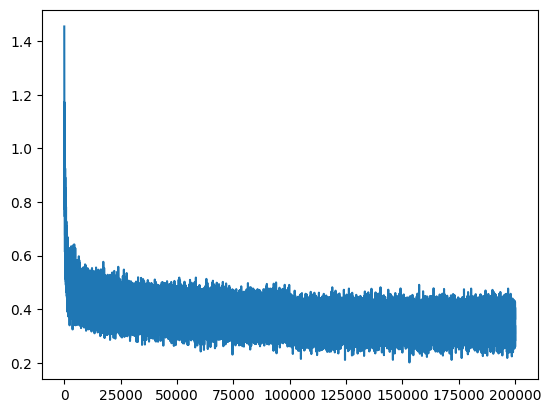

In [40]:
plt.plot(stepi, lossi)


In [44]:
#plt.plot(lri, lossi)


In [41]:
emb = C[Xtr] # (57, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (57, 100)
logits = h @ W2 + b2 # (57, 57)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2428, grad_fn=<NllLossBackward0>)

In [42]:
emb = C[Xdev] # (57, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (57, 100)
logits = h @ W2 + b2 # (57, 57)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4430, grad_fn=<NllLossBackward0>)

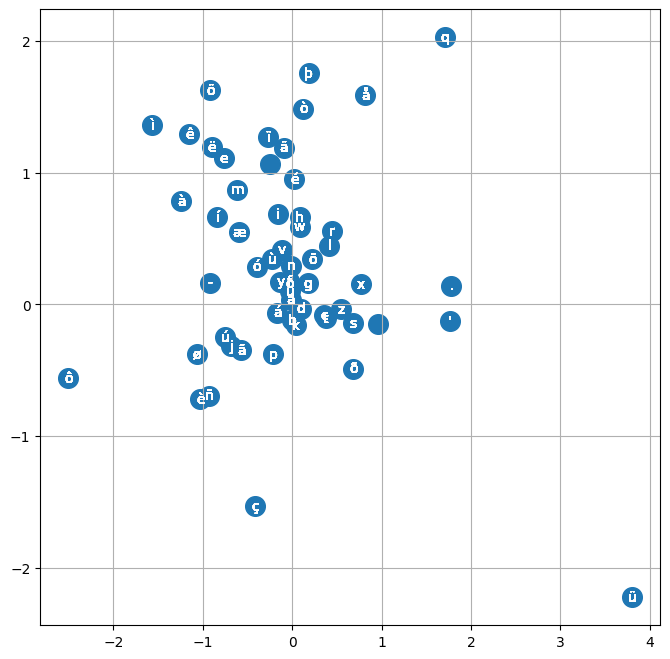

In [46]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  for i in itos:
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

 training split, dev/validation split, test split
 80%, 10%, 10%

In [47]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

jona.
dovenessa.
sameovie.
nerro.
gega.
kad.
zabela.
biffina.
momir.
abdus.
lucio.
sav.
honino.
cylperesodierok.
pan.
kaltanislavintachristona.
ouvinus.
bed.
hil.
yancisab.
